<a href="https://colab.research.google.com/github/AdiTheRipper/DL-Lab/blob/main/A4(smol).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/20
5/5 [==============================] - 3s 85ms/step - loss: 0.0107 - mse: 0.0242 - val_loss: 0.0128 - val_mse: 0.0295
Epoch 2/20
5/5 [==============================] - 0s 22ms/step - loss: 0.0101 - mse: 0.0228 - val_loss: 0.0123 - val_mse: 0.0285
Epoch 3/20
5/5 [==============================] - 0s 22ms/step - loss: 0.0093 - mse: 0.0208 - val_loss: 0.0120 - val_mse: 0.0276
Epoch 4/20
5/5 [==============================] - 0s 21ms/step - loss: 0.0083 - mse: 0.0186 - val_loss: 0.0116 - val_mse: 0.0268
Epoch 5/20
5/5 [==============================] - 0s 21ms/step - loss: 0.0073 - mse: 0.0163 - val_loss: 0.0114 - val_mse: 0.0263
Epoch 6/20
5/5 [==============================] - 0s 20ms/step - loss: 0.0065 - mse: 0.0145 - val_loss: 0.0110 - val_mse: 0.0255
Epoch 7/20
5/5 [==============================] - 0s 24ms/step - loss: 0.0058 - mse: 0.0131 - val_loss: 0.0108 - val_mse: 0.0248
Epoch 8/20
5/5 [==============================] - 0s 19ms/step - loss: 0.0054 - mse: 0.0120 - val

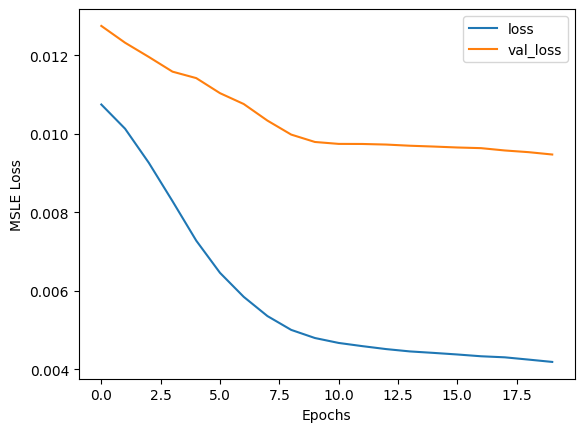

73/73 [==============================] - 0s 3ms/step
Threshold: 0.009067602064575875


In [1]:


# Importing libraries and dataset
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError

# Load the ECG dataset
PATH_TO_DATA = 'http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv'
data = pd.read_csv(PATH_TO_DATA, header=None)
data.head()

# Display the shape of the dataset
data.shape

# Separate features and target variable
features = data.drop(140, axis=1)
target = data[140]

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, stratify=target
)

# Extract training data for the positive class (Class 1)
train_index = y_train[y_train == 1].index
train_data = x_train.loc[train_index]

# Scale the features to the range [0, 1]
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(train_data.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

# Define the AutoEncoder model
class AutoEncoder(Model):
    def __init__(self, output_units, ldim=8):
        super().__init__()
        # Encoder layers
        self.encoder = Sequential([
            Dense(64, activation='relu'),
            Dropout(0.1),
            Dense(32, activation='relu'),
            Dropout(0.1),
            Dense(16, activation='relu'),
            Dropout(0.1),
            Dense(ldim, activation='relu')
        ])
        # Decoder layers
        self.decoder = Sequential([
            Dense(16, activation='relu'),
            Dropout(0.1),
            Dense(32, activation='relu'),
            Dropout(0.1),
            Dense(64, activation='relu'),
            Dropout(0.1),
            Dense(output_units, activation='sigmoid')
        ])

    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

# Initialize the AutoEncoder model
model = AutoEncoder(output_units=x_train_scaled.shape[1])

# Compile the model with optimizer, loss, and evaluation metric
model.compile(loss='msle', metrics=['mse'], optimizer='adam')

# Train the AutoEncoder model
epochs = 20
history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=epochs,
    batch_size=512,
    validation_data=(x_test_scaled, x_test_scaled)
)

# Plot the training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

# Function to find the threshold for anomaly detection
def find_threshold(model, x_train_scaled):
    reconstructions = model.predict(x_train_scaled)
    reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
    threshold = np.mean(reconstruction_errors.numpy()) + np.std(reconstruction_errors.numpy())
    return threshold

# Function to get predictions based on the threshold
def get_predictions(model, x_test_scaled, threshold):
    predictions = model.predict(x_test_scaled)
    errors = tf.keras.losses.msle(predictions, x_test_scaled)
    anomaly_mask = pd.Series(errors) > threshold
    preds = anomaly_mask.map(lambda x: 0.0 if x == True else 1.0)
    return preds

# Calculate the threshold for anomaly detection
threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")
